<a href="https://colab.research.google.com/github/jacquelinevanarkel/CulturalEvolutionCollateralSignals-2021/blob/main/Model_Winter_%26_Wedel_(2016).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replication of Winter & Wedel (2016) / Wedel (2012)

Because we decided to first replicate the study, everything about the collateral signals is left out (but taken into account for the ease of implementation later on). After the resutls are replicated, we adjust the model to introduce a division between word categories: communicative words and metacommunicative words.   

## General features

- An **agent** consists of a lexicon of $|W|$ word categories (let's start with 4).
    - A **word** is represented by a set of exemplars. 
        - An **exemplar** is represented by a vector that designates a point in an *n*-dimensional space. Let's start with 2 dimensions, and let's have them both range arbitrarily from 0 to 100 (with integer values in between). An example of an exemplar would then be $[15, 25]$ (these individual values in the vector, like 15 and 25, are referred to as "segments" by Wedel, 2012).


- **Initialisation of an agent:** <span class="mark">Just a randomly generated seed set of exemplars for each word category?</span>

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math

In [171]:
class Agent():

  def __init__(self, n_words, n_dimensions, n_exemplars = 100, n_continuers=0):
    
    self.n_words = n_words
    self.n_dimensions = n_dimensions
    self.n_exemplars = n_exemplars
    self.n_continuers = n_continuers

    # # Generate a lexicon as part of the initialisation
    # self.lexicon, self.com_words, self.meta_com_words = self.generate_lexicon()

  # Initialising lexicon
  def generate_lexicon(self):

    # Create a lexicon consisting of n_words words each in turn consisting of n_exemplars exemplars
    lexicon = []
    for w in range(self.n_words):
      word = []

      # Define the mean and the covariance to sample from a multivariate normal distribution to create clustered exemplars for the words
      mean = [random.randrange(10, 91) for i in range(self.n_dimensions)]
      cov = [[10, 0], [0, 10]]
      x, y = np.random.multivariate_normal(mean, cov, self.n_exemplars).T
      word.append(list(map(lambda x, y: [x, y], x, y)))
      
      # Plot every word
      plt.scatter(x, y)

      # Initialiase all words as 'communicative words' ('C')
      lexicon.append([word[0], "C"])

    # print(lexicon)

    # Some plot settings
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.show()

    # Split the lexicon into meta communicative words (continuers) and communicative words
    if self.n_continuers:
      if self.n_continuers > self.n_words:
        raise ValueError("The number of continuers must be lower than the number of words.")

      # The continuers are randomly chosen out of the lexicon
      indices_meta = random.sample(range(self.n_words), k=self.n_continuers)
      meta_com_words = []
      for index in indices_meta:
        lexicon[index][1] = "M"
        # Create a separate lexicon with the meta communicative words
        meta_com_words.append(lexicon[index])

      # The words that are not meta communicative words are communicative words
      com_words = [word for word in lexicon if word not in meta_com_words]

      # print("The word categories are split into communicative and metacommunicative words")
      # print("New lexicon:", lexicon)

      # print("Meta:", meta_com_words)
      # print("Com:", com_words)

    # If there are no continuers, the meta communicative words list is empty and all the words in the lexicon are communicative words
    else:
      com_words = lexicon
      meta_com_words = []

    return lexicon, com_words, meta_com_words

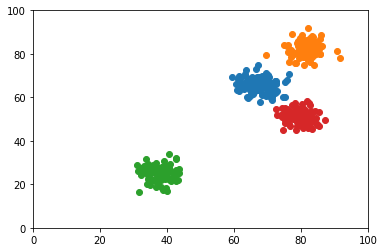

In [172]:
# Test the initialisation
lexicon, com_words, meta_com_words = Agent(4, 2).generate_lexicon()

## Production:

Production begins by selecting one exemplar from a word category: An exemplar is chosen from the target word category with probability proportional to the exemplar's activation level. 
- **Activation level:** 
    - _"Each new exemplar is associated with an initial activation value that decreases over time (i.e., memory decay; Hintzman, 1986; Nosofsky, 1986; Pierrehumbert, 2001)."_ (Winter & Wedel, 2016)
    - _"Activation is calculated as an exponential function of recency, where exemplars that were stored 100 rounds previously have an activation level that is approximately .1% that of a new exemplar)."_ (Wedel, 2012)
    - _"In the model runs shown here, the activation of a exemplar is modeled as $e^{0.2j}$, where $j$ is its list position; this results in a exemplar at position 100 having an activation that is approximately .01 times that of an exemplar at position 1."_ (Wedel, 2012; Appendix)
    ### Question: I think there is a mistake here? (Currently implemented as 1/(0.2*j))
    - _"The probability of an exemplar being chosen as a production target is its activation relative to the total activation of all exemplars in the category."_ (Wedel, 2012; Appendix)
    - _"Exemplars at list positions greater than 100 are discarded after every round to keep computation efficient; preserving more exemplars slows the rate of change in the system but otherwise does not qualitatively change system behavior."_ (Wedel, 2012; Appendix)
  
Before this target is passed to the listener however, two biases are applied to it:"
- **Similarity biases:** Consists of the following two components:
    - **Within-word category similarity bias:** _"The segment exemplar values of this initial word target are stochastically biased toward the value at the same positions in all the word exemplars within the category"_
        - _"At the word level, population vectors are calculated for the segment values in the target word relative to all segment values at the same position over all exemplars within that word category"_ (Wedel, 2012; Appendix)
    - **Within-segment-dimension similarity bias:** _"each individual segment exemplar value in the target is also stochastically biased toward all other segment exemplars that reference the same dimension across the entire lexicon"_ 
        - _"At the segment level, population vectors are calculated for the segment values in the target word relative to all segment values on that dimension across the lexicon."_ (Wedel, 2012; Appendix)
    - _"To model the influence of both word and segment recency and similarity on production variation, the population vectors at each segment dimension at each level are combined to create a new output that combines information from both within-word category, and within-lexicon sources. The relative contribution of word versus segment population vectors to the output was fixed at .9."_ (Wedel, 2012; Appendix) Marieke: <span class="mark"> --> Wait, what does that last bit mean exactly? That the segment-level population vector contributes 9/10th of what the word-level population vector contributes? Or the other way around? Or something else entirely? Not sure how to interpret this... The Wedel (2012) Appendix refers to the following two articles in this context: (Guenther and Gjaja 1996; Oudeyer 2002); maybe those references could help us? (Also quite likely they won't though.) </span> 
Jacqueline: I think the first option indeed, that the segment-level population contributes 9/10th of what the world-level population contributes, this also makes sense I guess, as the segments within a word should influence each other more, than over the entire lexicon (you produce the different sounds of a word closer to each other than the different sounds of all the words combined of your lexicon right?)
    - _"The population vector with respect to a particular point within a particular segment dimension is a weighted average of all segment exemplars mapped to the category, where both the Euclidean distance from the target exemplar and activation influence each exemplar’s contribution. This is conceptually the same as Nosofsky’s Generalized Context model (Nosofsky 1988), modified to take exemplar activation into account. The formula used to incorporate these factors is given below, where $p$ is the output population vector, y is each position within the segment dimension value of the target under production, $w_y$ is the activation of the exemplar, $x$ is the reference point chosen as the basis for production, and $k$ is a scaling factor influencing the fall off of the contribution to the population vector of the point $y$ relative to $x$:"_ (Wedel, 2012; Appendix)

$$ p = \frac{\sum_y yw_{y} e^{-k |x-y|}}{\sum_{y} w_{y} e^{-k |x-y|}} $$

- _"The value of $k$ used in the simulations shown here is 0.2; a larger value of $k$ reduces the effect of more distant values on the population vector."_ (Wedel, 2012; Appendix). --> Let us start with $k = 0.2$ as well, but make $k$ into a parameter that we can change just in case.


- **Random noise:** _"Noise is added to values of the output target by adding a normally distributed random value. This random value is biased slightly toward the center of the dimension, (i.e. a scale value of 50), in a simple model of production-based lenition (Pierrehumbert 2001; see also e.g. Lindblom et al. 1984 for arguments that the packing of phoneme inventories is in part a consequence of effort-minimization processes). The results described below do not depend on this lenition bias, but they contribute to the illustration by imposing a tendency for each segment exemplar distribution to drift toward the center of each dimension which encourages category merger (see discussion below)."_ 
    - _"Finally, a Gaussian random variable with a standard deviation of 3 is added to the output to introduce noise. This variable is biased slightly toward the center of the dimensional space, creating a fixed attractor at the center of each segment dimension in the system. The bias is calculated using a parabolic response curve given below, where $b$ is the bias added to the output population vector, $p$ is the output population vector, $N$ is the number of points in the space and $G$ is a constant; $b$ is subtracted from outputs greater than $N/2$ (here, 50) and added to those below it."_ (Wedel, 2012; Appendix)
    ### Question: Not sure if I understood this correctly: you calcuate this bias value, and add this up to a Gaussian random variable with a sd of 3 (and mean of the target to be produced)?
    
$$ b = \frac{(p-N/2)^2}{G}$$

- _"The value of G used in these simulations was 5000, giving a bias toward the center of 0.5 at the edges of the continuum. All else being equal, this bias shifts the distributions of both categories toward the center of the dimension over time, i.e. toward 50, which corresponds to a simple model of articulatory undershoot (cf. Lindblom 1983; Pierrehumbert 2001)."_ (Wedel, 2012; Appendix)

In [173]:
class Production():

  def __init__(self, lexicon, com_words, meta_com_words, n_words, n_dimensions, n_exemplars = 100, n_continuers=0, similarity_bias_word=True, similarity_bias_segment=True, noise=True):
    
    self.lexicon = lexicon
    self.com_words = com_words
    self.meta_com_words = meta_com_words
    self.n_words = n_words
    self.n_dimensions = n_dimensions
    self.n_exemplars = n_exemplars
    self.n_continuers = n_continuers
    self.similarity_bias_word = similarity_bias_word
    self.similarity_bias_segment = similarity_bias_segment
    self.noise = noise

  def select_exemplar(self):

    # Select a target exemplar for every word category
    targets = []
    total_activations = []
    for word_index in range(self.n_words):

      # Only store exemplars until position 100
      exemplars = self.lexicon[word_index][0][:101]

      # First calculate the activation of every exemplar
      print("EXEMPLARS BEGINNING: ", exemplars)
      activation_exemplars = []
      j = 1
      for exemplar in exemplars: 
        # activation = math.exp(0.2*j)
        activation = 1/(0.2*j)
        activation_exemplars.append(activation)
        j += 1

      # Store all the activations for all exemplars and all words
      total_activations.append(activation_exemplars)
      # print("Activation exemplars: ", activation_exemplars)

      # Calculate the sum of the activation of the exemplars of the word
      activation_word = sum(activation_exemplars)
      # print("Activation word: ", activation_word)

      # Calculate the probabilities of the exemplar being chosen to produce for that word category
      exemplar_probs = [activation/activation_word for activation in activation_exemplars]
      # print("Exemplars probability: ", exemplar_probs)
      # max_prob = max(exemplar_probs)
      # print("Max probability: ", max_prob)

      # Choose an exemplar to produce based on their probabilities 
      target = random.choices(exemplars, weights = exemplar_probs, k = 1)
      print("CHOSEN EXEMPLARS: ", target)

      # Store the exemplars for every word to be produced
      targets.append(target[0])
      # print(targets)

    return targets, activation_exemplars, total_activations

  def add_biases(self, targets, activation_exemplars, total_activations, k=0.2):
    
    # Add the biases to every target (one target per word) before production
    word_index = 0
    target_exemplars = []
    for target in targets:

      # Select only the first 100 exemplars per word
      exemplars = self.lexicon[word_index][0][:101]

      # If both similarity biases are added to the target, they are combined
      if self.similarity_bias_word and self.similarity_bias_segment:
        word_bias = self.similarity_word(target, exemplars, activation_exemplars, k)
        segment_bias = self.similarity_segment(target, total_activations, k)

        # The ratio of the word similarity to the segment similarity is 9/10
        total_bias = [(9*a) + b for a, b in zip(word_bias, segment_bias)]
        target = [bias / 10 for bias in total_bias]

      elif self.similarity_bias_word:
        target = self.similarity_word(target, exemplars, activation_exemplars, k)
        
      elif self.similarity_bias_segment:
        target = self.similarity_segment(target, total_activations, k)

      # If noise is added, it should be added to the target exemplar after the other biases have been added
      if self.noise: 
        target = self.add_noise(target)
      
      # Store all the targets after the biases have been added
      target_exemplars.append(target)
      word_index += 1

    print("BEFORE BIASES:", targets)
    print("WITH BIASES:", target_exemplars)

    return target_exemplars

  def similarity_word(self, target, exemplars, activation_exemplars, k):

    # For every segment (dimension) the similarity is calculated and the similarity bias is added
    bias_exemplar = []
    for dimension in range(self.n_dimensions):
      index = 0
      sum = 0
      sum2 = 0

      # This is done for every exemplar in the word (see the equation)
      for exemplar in exemplars:
        sum += exemplar[dimension] * activation_exemplars[index] * math.exp(-k * abs(target[dimension]-exemplar[dimension]))
        sum2 += activation_exemplars[index] * math.exp(-k * abs(target[dimension]-exemplar[dimension]))
        index += 1

      # Finally the target with the similarity bias is stored for the two dimensions
      bias_exemplar.append(sum/sum2)

    print("SIMILARITY WORD ADDED: ", bias_exemplar)

    return bias_exemplar

  def similarity_segment(self, target, total_activations, k):

    # For every segment (dimension) of all exemplars (of all words) the similarity is calculated and a bias is added to the target
    bias_exemplar = []

    # Every segment (dimension) is compared for its similarity
    for dimension in range(self.n_dimensions):
      word_index = 0
      sum = 0
      sum2 = 0

      # This is done for all the words in the lexicon
      for word in self.lexicon:
        index = 0
        # print("word_index:", word_index)

        # Every exemplar is compared to the target exemplar
        for exemplar in word[0]:
          # print("Ex dimension: ", exemplar[dimension])
          # print("activations: ", total_activations[word_index][index])
          # print("Math: ", math.exp(-k * abs(target[dimension]-exemplar[dimension])))

          # According to the equation, the similarity of the target to every exemplar is calculated and added as a bias
          sum += exemplar[dimension] * total_activations[word_index][index] * math.exp(-k * abs(target[dimension]-exemplar[dimension]))
          # print("sum: ", sum)
          sum2 += total_activations[word_index][index] * math.exp(-k * abs(target[dimension]-exemplar[dimension]))
          index += 1
        word_index += 1

      # The target including the word similarity bias is stored for both dimensions
      bias_exemplar.append(sum/sum2)
    
    print("SIMILARITY SEGMENT ADDED: ", bias_exemplar)

    return bias_exemplar

  def add_noise(self, target, G = 5000):

    target_noise = []

    # For every segment in the target exemplar noise is added
    for segment in target:
      N = 100

      # First the bias is calculated
      bias = ((segment - (N/2))**2)/G

      # A new target is sampled from a normal distribution with sd 3 and the mean of the target segment
      new_target = np.random.normal(segment, 3, 1)

      # The biases is substracted or added based on the target segment value
      if segment > N/2:
        added_noise = new_target[0] - bias
      else:
        added_noise = new_target[0] + bias

      # The noise of the segments is stored (as we have multiple dimensions)
      target_noise.append(added_noise)
    print("NOISE ADDED: ", target_noise)

    return target_noise

In [174]:
targets, activation_exemplars, total_activations = Production(lexicon, com_words, meta_com_words, 4, 2).select_exemplar()
print(targets)
target_exemplars = Production(lexicon, com_words, meta_com_words, 4, 2).add_biases(targets, activation_exemplars, total_activations)
print(target_exemplars)

EXEMPLARS BEGINNING:  [[68.36208238139429, 61.057472002849416], [67.00802460304446, 65.08356884082863], [64.76627178315964, 68.29661249949856], [64.82953763989565, 68.47540340601637], [64.41787467779271, 64.58393768456745], [72.37054332225942, 61.79808490413787], [72.91410589577875, 62.76788651064005], [65.35300204097625, 66.15457787893855], [70.6369239896442, 66.66818577838785], [71.23514955712952, 60.25760429736472], [63.98081443614557, 60.05968203484854], [65.92825755988943, 68.79770601787709], [69.56403823334654, 60.46025600709815], [61.52751845389981, 65.8605237852814], [69.187328831192, 64.52652357403588], [59.322307920491674, 69.48154543450745], [70.25799098359708, 65.90240531247112], [67.37487403848364, 69.53577557700993], [67.01172717307897, 63.580266108580766], [74.56494338827505, 60.357280762938345], [69.60953323330696, 66.34999799273582], [66.44954785378492, 72.9118239068211], [71.55504026136225, 64.00537995092549], [67.96879694445562, 67.44787476756032], [72.60289935404322

##Perception:
        
_"begins the categorization process by calculating the similarity of the speaker output to each category’s stored word exemplars given their activations, in a variant of the Generalized Context Model (Nosofsky 1988). The overall similarities of the speaker output to each category are interpreted as a relative goodness of fit, and the speaker output is then stored as a new exemplar in the best fitting category."_

- **Anti-ambiguity bias:** From Winter & Wedel (2016): _"A final feature of the model is a bias against confusability of word perception, that is, an anti-ambiguity bias. The bias is implemented as follows: the probability of successful identification of an output with a word category is proportional to the degree to which the output uniquely maps to that category and to no other. In this way, distinctive speaker outputs are more likely to be stored than ambiguous outputs, with the result that distinctive phonetic values contribute more to the continuing evolution of the lexicon, both at the word and sound levels."_

### Question: This entire part I'm not sure of. I calcualted the similarity according to the equation above, but this did not make sense in terms of output. So I only calculated the sum in the numerator for all the exemplars of all words. Then the word category with the highest similarity was chosen. The probability of storing the signal into this category is calculated by the similarity of the signal to the chosen word category divided by the sum of all the similarities. Then the signal was stored into the chosen word category with this probability.

In [175]:
class Perception():

  def __init__(self, lexicon, com_words, meta_com_words, n_words, n_dimensions, n_exemplars = 100, n_continuers=0, anti_ambiguity_bias=True):
      
      self.lexicon = lexicon
      self.com_words = com_words
      self.meta_com_words = meta_com_words
      self.n_words = n_words
      self.n_dimensions = n_dimensions
      self.n_exemplars = n_exemplars
      self.n_continuers = n_continuers
      self.anti_ambiguity_bias = anti_ambiguity_bias

  def similarity(self, signal, k=0.2):

    # Calculate the activations first
    targets = []
    total_activations = []
    for word_index in range(self.n_words):

      # Only store exemplars until position 100
      exemplars = self.lexicon[word_index][0][:101]

      print("EXEMPLARS BEGINNING: ", exemplars)
      activation_exemplars = []
      j = 1
      for exemplar in exemplars: 
        # activation = math.exp(0.2*j)
        activation = 1/(0.2*j)
        activation_exemplars.append(activation)
        j += 1

      total_activations.append(activation_exemplars)

    # Calculate the similarity of the signal to all the exemplars of all the words
    similarities = []
    word_index = 0

    # Iterate over all the words
    for word_index in range(self.n_words):
      exemplar_sim = []

      # Iterate over all the dimensions (to access the segments)
      for dimension in range(self.n_dimensions):
        index = 0
        sum = 0
        sum2 = 0

        # Calculate the similarity of a segment of the signal compared to all the exemplars in a word
        for exemplar in self.lexicon[word_index][0][:101]:
          sum += exemplar[dimension] * total_activations[word_index][index] * math.exp(-k * abs(signal[dimension]-exemplar[dimension]))
          sum2 += total_activations[word_index][index] * math.exp(-k * abs(signal[dimension]-exemplar[dimension]))
          index += 1
        exemplar_sim.append(sum)

      word_index += 1

      # Store the similarities for every exemplar of every word
      similarities.append(exemplar_sim)

      # Take the sum of the similarities within a word category
      total_similarities = []
      for word_cat in similarities:
        sum = np.sum(word_cat)
        total_similarities.append(sum)
    # print(similarities)
    # print(total_similarities)

    # Get the word with the highest similarity to the signal
    max_similarity = max(total_similarities)
    index_max_sim = total_similarities.index(max_similarity)
    print("SIGNAL MOST SIMILAR TO WORD: ", index_max_sim)

    return index_max_sim, total_similarities

  def add_anti_ambiguity_bias(self, index_max_sim, total_similarities, signal):

    # The probability whether the signal is stored is calculated by its similarity to the word category divided to the sum of its similarity to all word categories

    # print(1/total_similarities[index_max_sim])
    # print(sum(total_similarities))
    probability_storage = (total_similarities[index_max_sim])/sum(total_similarities)
    # print(probability_storage)

    # Determine whether the signal is stored based on the probability calculated
    store = random.choices([True, False], weights = [probability_storage, 1-probability_storage], k = 1)

    # If the signal is stored, the signal is stored in the lexicon as the first segment of the previously determined word category
    if store[0]:
      self.lexicon[index_max_sim][0].insert(0, signal)  

    print(self.lexicon[index_max_sim])

    return self.lexicon

EXEMPLARS BEGINNING:  [[68.36208238139429, 61.057472002849416], [67.00802460304446, 65.08356884082863], [64.76627178315964, 68.29661249949856], [64.82953763989565, 68.47540340601637], [64.41787467779271, 64.58393768456745], [72.37054332225942, 61.79808490413787], [72.91410589577875, 62.76788651064005], [65.35300204097625, 66.15457787893855], [70.6369239896442, 66.66818577838785], [71.23514955712952, 60.25760429736472], [63.98081443614557, 60.05968203484854], [65.92825755988943, 68.79770601787709], [69.56403823334654, 60.46025600709815], [61.52751845389981, 65.8605237852814], [69.187328831192, 64.52652357403588], [59.322307920491674, 69.48154543450745], [70.25799098359708, 65.90240531247112], [67.37487403848364, 69.53577557700993], [67.01172717307897, 63.580266108580766], [74.56494338827505, 60.357280762938345], [69.60953323330696, 66.34999799273582], [66.44954785378492, 72.9118239068211], [71.55504026136225, 64.00537995092549], [67.96879694445562, 67.44787476756032], [72.60289935404322

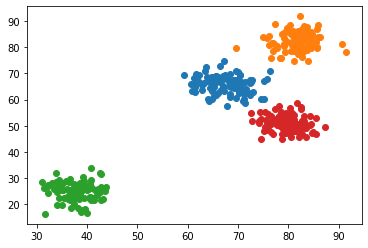

In [176]:
for signal in target_exemplars:
  index_max_sim, total_similarities = Perception(lexicon, com_words, meta_com_words, 4, 2).similarity(signal)
  lexicon = Perception(lexicon, com_words, meta_com_words, 4, 2).add_anti_ambiguity_bias(index_max_sim, total_similarities, signal)
  print(lexicon)

for word_index in range(4):
  exemplars = lexicon[word_index][0]
  plt.scatter(*zip(*exemplars))